# Exp: to build Vanilla Auto Encoder for MNIST generation with Keras

## Step1: load the data

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist

In [3]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [35]:
from tensorflow.keras.utils import to_categorical

num_class = 10

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [36]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Step2: define the encoder's model structure

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Reshape
from tensorflow.keras.backend import int_shape

z_dim = 2 # the dim of hidden feature space

In [38]:
# input layer
encoder_input_layer = Input(shape=(28,28,1))
# conv layer 1
x = Conv2D(
    filters = 32, kernel_size = (3,3),
    strides = 1, padding = 'same'
)(encoder_input_layer)
x = LeakyReLU()(x)
# conv layer 2
x = Conv2D(
    filters = 64, kernel_size = (3,3),
    strides = 2, padding = 'same'
)(x)
x = LeakyReLU()(x)
# conv layer 3
x = Conv2D(
    filters = 64, kernel_size = (3,3),
    strides = 2, padding = 'same'
)(x)
x = LeakyReLU()(x)
# conv layer 4
x = Conv2D(
    filters = 64, kernel_size = (3,3),
    strides = 1, padding = 'same'
)(x)
x = LeakyReLU()(x)
# flatten layer
unflatten_shape = int_shape(x)[1:]
x = Flatten()(x)
flatten_shape = x.shape[1] # after flatten layer, x.shape = [None,flatten_size]
# dense layer / output layer
encoder_output_layer = Dense(
    units = z_dim
)(x)

encoder = Model(encoder_input_layer,encoder_output_layer)
encoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 7, 7, 64)          0  

## Step3: define the decoder's model structure (inverse-order of encoder's)

In [39]:
# input layer
from tensorflow.keras.layers import Reshape
decoder_input_layer = Input(shape=(z_dim,))
# dense layer
x = Dense(
    units = flatten_shape,
)(decoder_input_layer)
x = Reshape(target_shape=unflatten_shape)(x)
# conv-T layer 1
x = Conv2DTranspose(
    filters = 64, kernel_size = (3,3),
    strides = 1, padding = 'same'
)(x)
x = LeakyReLU()(x)
# conv-T layer 2
x = Conv2DTranspose(
    filters = 64, kernel_size = (3,3),
    strides = 2, padding = 'same'
)(x)
x = LeakyReLU()(x)
# conv-T layer 3
x = Conv2DTranspose(
    filters = 32, kernel_size = (3,3),
    strides = 2, padding = 'same'
)(x)
x = LeakyReLU()(x)
# output layer
decoder_output_layer = Conv2DTranspose(
    filters = 1, kernel_size = (3,3),
    strides = 1, padding = 'same',
    activation = 'sigmoid'
)(x)

decoder = Model(decoder_input_layer,decoder_output_layer) 
decoder.summary() # decoder's structure is not necessary to be the inverse-same with encoder's
# as long as their input_size and output_size inverse-matched

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 14, 14, 64)        0  

## Step 4: define the full coder model structure

In [40]:
model_input_layer = encoder_input_layer
model_output_layer = decoder(encoder_output_layer)

model = Model(model_input_layer,model_output_layer)
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 7, 7, 64)          0  

## Step 5: compile the model

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
optimizer = Adam(lr=0.0005)

def rmse_loss(y_true,y_pred):
    return K.mean(
        K.square(y_true-y_pred), axis = [1,2,3] # the rmse among pixel-shape (28,28,1)
    )

model.compile(optimizer = optimizer,loss = rmse_loss)

## Step6: train the model

In [42]:
model.fit(
    x = x_train, y = x_train,
    batch_size = 32, epochs = 10, shuffle = True
)

Epoch 1/10
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0547
Epoch 2/10
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0460
Epoch 3/10
1875/1875 [==============================] - 124s 66ms/step - loss: 0.0440
Epoch 4/10
1875/1875 [==============================] - 138s 74ms/step - loss: 0.0429
Epoch 5/10
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0423
Epoch 6/10
1875/1875 [==============================] - 132s 71ms/step - loss: 0.0418
Epoch 7/10
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0413
Epoch 8/10
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0410
Epoch 9/10
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0408
Epoch 10/10
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0405


## Step7: show the generation effect

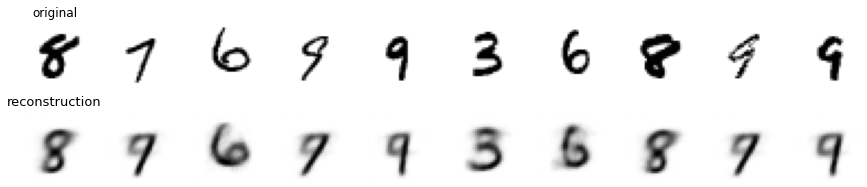

In [54]:
import matplotlib.pyplot as plt
n_to_show = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = encoder.predict(example_images) # encode the example images to latent space
reconst_images = decoder.predict(z_points) # reconstruct the example images from latent space

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    if i == 0:
        ax.set_title('original')
        ax.text(0.5, -0.35, 'reconstruction', fontsize=13, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

## Step8: show the latent space distribution

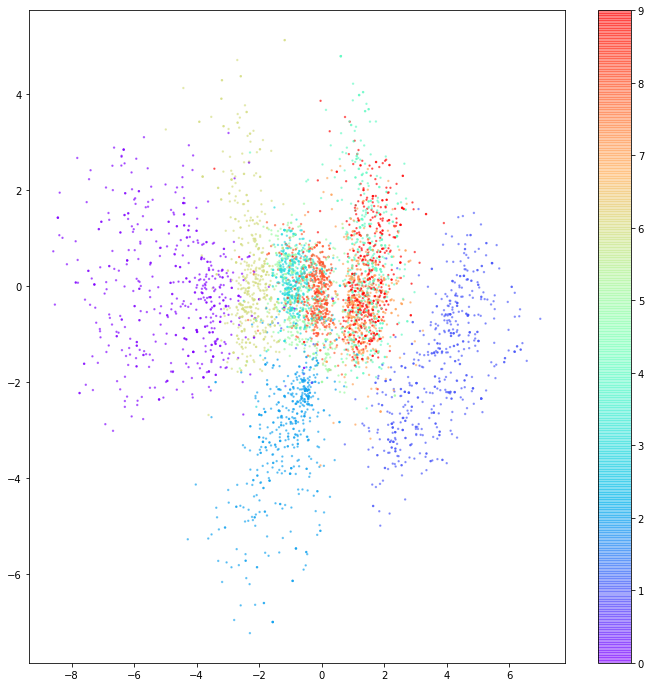

In [51]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = np.argmax(y_test[example_idx],axis=-1)

z_points = encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], 
            cmap ='rainbow' , c = example_labels, alpha=0.5, s=2)
plt.colorbar()
plt.show()

$\Rightarrow$ The latent space is not symmetric centered at (0,0)

$\Rightarrow$ The borders between different numbers are mixed and dependent

$\Rightarrow$ The area of different numbers are quite different

## Step9: show the new generation effect

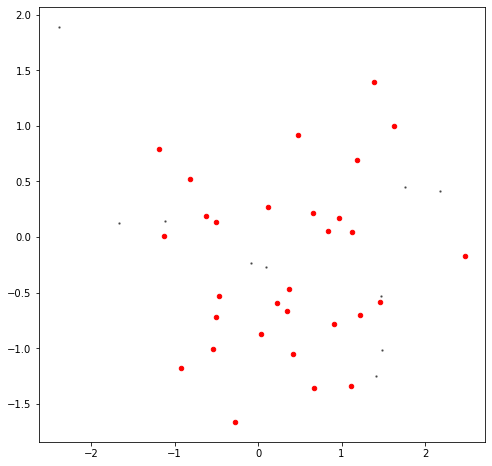

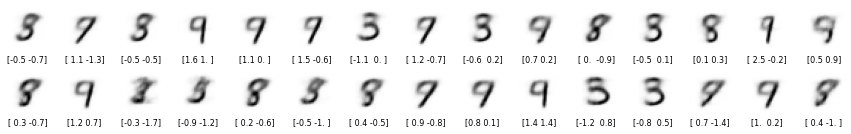

In [55]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')